In [30]:
import numpy as np
from tqdm.contrib.itertools import product
a = np.load("collision_states_6m_12s_RVO.npy")

index = 0
metric_dict = {}
round_metrics_dict = {}

for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        survive_times = []
        for start_time in range(0, 240, 40):
            survive_time = 0
            while (start_time + survive_time < 240) and (not (a[index,::2,::2,start_time+survive_time].any())):
                survive_time += 1
            survive_times.append(survive_time)
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = np.mean(survive_times) / 10
        index += 1

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

# Import data

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
import ast
from tqdm.contrib.itertools import product

df_metric = pd.read_csv('./experiment/metrics/density.csv')
metrics = []
for i in range(20):
    metrics.append(ast.literal_eval(df_metric['metric'][i]))
data = np.array(metrics).flatten()
metric_dict = {}
round_metrics_dict = {}
index = 0
for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = data[index]
        round_metrics_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = round(data[index])
        index += 1

# df_metric = pd.read_csv('./experiment/metrics/metrics_6m_12s_RVO.csv')
# metrics = []
# for i in range(20):
#     metrics.append(ast.literal_eval(df_metric['metric'][i]))
# data = np.array(metrics).flatten()
# index = 0
# for map_id in range(20):
#     for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
#         metric_dict[(map_id, agent_num, agent_size, agent_vel, 'RVO')] = data[index]
#         round_metrics_dict[(map_id, agent_num, agent_size, agent_vel, 'RVO')] = round(data[index])
#         index += 1


directory_path = "./experiment/validation/"

# Get all CSV file names in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df['Planner'] = df['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df['Method'] = df['Method'].replace({'NoControl': 'FullRange'})

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

# Plot scatter figure of surviving time vs. success rate for different planners

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools


df_filtered = df[(df['Motion Profile'] == 'CVM')]
# Define the columns to sort by
sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']

# Add a new column to the dataframe for the combinations of 'Method' and 'Planner'
df_filtered['Method_Planner'] = df_filtered['Method'] + "+" + df_filtered['Planner']
df_filtered['map difficulty'] = df_filtered.apply(lambda row: metric_dict.get((row['Map ID'], row['Number of agents'], row['Agent size'], row['Agent speed'], row['Motion Profile']), 'N/A'), axis=1)

# Calculate success rates for all combinations of parameters and 'Method_Planner'
df_filtered['Parameters'] = df_filtered[sort_columns].apply(tuple, axis=1)
df_grouped = df_filtered.groupby(['Method_Planner', 'Parameters'])['Success'].mean().reset_index()
df_grouped['map difficulty'] = df_grouped.apply(lambda row: metric_dict.get(row['Parameters'], 'N/A'), axis=1)



/tmp/ipykernel_35021/3281584345.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Method_Planner'] = df_filtered['Method'] + "+" + df_filtered['Planner']
/tmp/ipykernel_35021/3281584345.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['map difficulty'] = df_filtered.apply(lambda row: metric_dict.get((row['Map ID'], row['Number of agents'], row['Agent size'], row['Agent speed'], row['Motion Profile']), 'N/A'), axis=1)
/tmp/ipykernel_35021/3281584345.py:17: SettingWithCopyWarni

Spearman's rank correlation coefficient for LookGoal+Global Primitive: -0.432 (p-value: 0.000)
Spearman's rank correlation coefficient for Oxford+Global Primitive: -0.508 (p-value: 0.000)
Spearman's rank correlation coefficient for LookAhead+Global Primitive: -0.433 (p-value: 0.000)
Spearman's rank correlation coefficient for Owl+Local Primitive: -0.501 (p-value: 0.000)
Spearman's rank correlation coefficient for FullRange+Global Primitive: -0.428 (p-value: 0.000)
Spearman's rank correlation coefficient for Owl+Global Primitive: -0.468 (p-value: 0.000)
Spearman's rank correlation coefficient for FullRange+Local Primitive: -0.490 (p-value: 0.000)
Spearman's rank correlation coefficient for LookAhead+MPC: -0.553 (p-value: 0.000)
Spearman's rank correlation coefficient for Owl+MPC: -0.567 (p-value: 0.000)
Spearman's rank correlation coefficient for LookAhead+Local Primitive: -0.465 (p-value: 0.000)
Spearman's rank correlation coefficient for FullRange+MPC: -0.662 (p-value: 0.000)
Average 

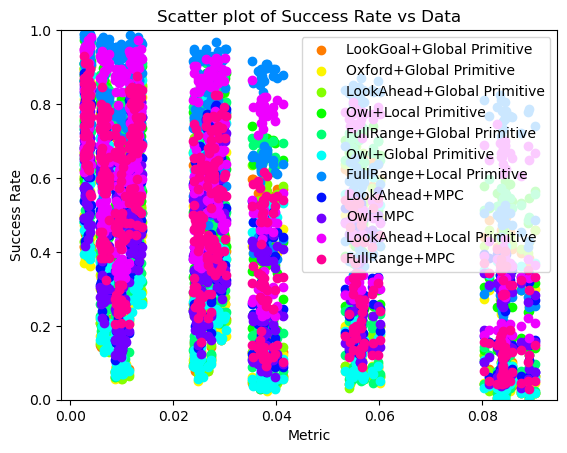

In [48]:
from scipy.stats import spearmanr
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_filtered['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))

coefs = []

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_grouped[df_grouped['Method_Planner'] == method_planner]
    plt.scatter(df_plot['map difficulty'], df_plot['Success'], color=color_map[method_planner], label=method_planner)
    coef, p = spearmanr(df_plot['map difficulty'], df_plot['Success'])
    coefs.append(coef)
    print(f"Spearman's rank correlation coefficient for {method_planner}: {coef:.3f} (p-value: {p:.3f})")

print(f"Average Spearman's rank correlation coefficient: {np.mean(coefs):.3f}")
print(f"std Spearman's rank correlation coefficient: {np.std(coefs):.3f}")

# Set the axis labels
plt.xlabel('Metric')
plt.ylabel('Success Rate')
# plt.xlim(10, 20)
plt.ylim(0, 1)

# Set the title
plt.title('Scatter plot of Success Rate vs Data')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Plot line chart with variance

In [49]:
df_filtered['Parameters'] = df_filtered[sort_columns].apply(tuple, axis=1)
grouped = df_filtered.groupby(['Method_Planner', 'Parameters', 'map difficulty'])
df_grouped = grouped.agg({'Success': 'mean', 'Dead Lock': 'mean'}).reset_index()

df_grouped['map difficulty'] = df_grouped.apply(lambda row: 100*metric_dict.get(row['Parameters'], 'N/A'), axis=1)


grouped = df_grouped.groupby(['Method_Planner', 'map difficulty'])['Success']
grouped_deadlock = df_grouped.groupby(['Method_Planner', 'map difficulty'])['Dead Lock']
mean_success = grouped.mean()
var_success = grouped.var()
mean_deadlock = grouped_deadlock.mean()
var_deadlock = grouped_deadlock.var()


# Create a DataFrame for results
df_results = pd.DataFrame({
    'Mean Success': mean_success,
    'Variance Success': var_success,
    'Mean Deadlock': mean_deadlock,
    'Variance Deadlock': var_deadlock
}).reset_index()

/tmp/ipykernel_35021/4207165579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Parameters'] = df_filtered[sort_columns].apply(tuple, axis=1)


Average Coefficient of Variation: 0.540
std Coefficient of Variation: 0.152


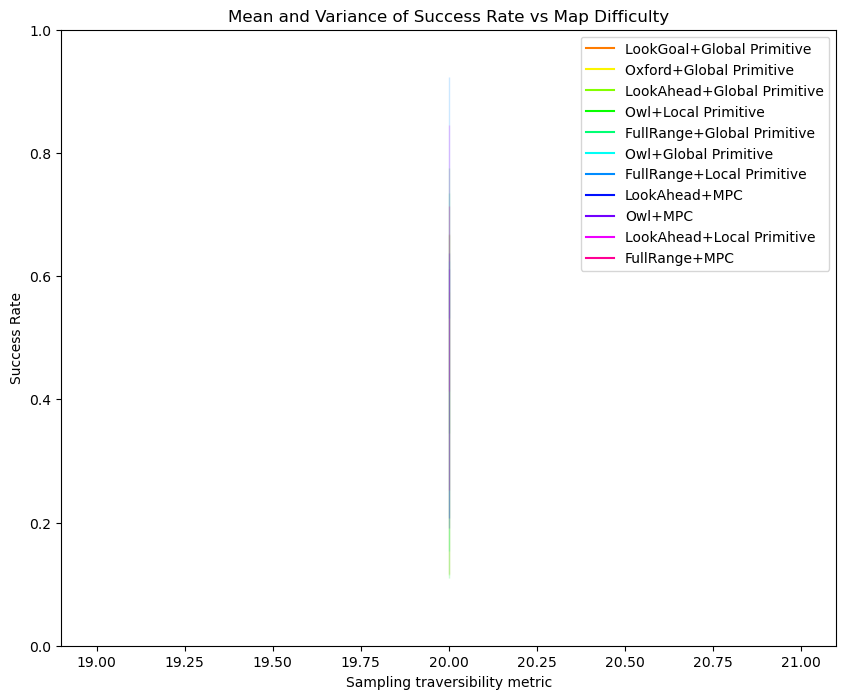

In [50]:
# Plot mean success rate and variance for each 'Method_Planner'
from scipy.stats import variation

plt.figure(figsize=(10,8))

cvs = []

for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    plt.plot(20 - df_plot['map difficulty'], df_plot['Mean Success'], 
             color=color_map[method_planner], label=method_planner)
    
    # Here we create the shaded variance region
    plt.fill_between(20 - df_plot['map difficulty'], 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)
    # Compute coefficient of variation at each point
    cv = np.sqrt(df_plot['Variance Success']) / df_plot['Mean Success']
    
    # Calculate the average coefficient of variation for the curve
    avg_cv = np.mean(cv)
    cvs.append(avg_cv)
    
    # print(f"Average Coefficient of Variation for {method_planner}: {avg_cv:.3f}")

# Set the axis labels
print(f"Average Coefficient of Variation: {np.mean(cvs):.3f}")
print(f"std Coefficient of Variation: {np.std(cvs):.3f}")
plt.xlabel('Sampling traversibility metric')
plt.ylabel('Success Rate')
plt.ylim(0, 1)
# plt.xlim(0, 16)

# Set the title
plt.title('Mean and Variance of Success Rate vs Map Difficulty')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Bar plot

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Separate 'Method' and 'Planner' in 'Method_Planner'
df_results['Method'], df_results['Planner'] = df_results['Method_Planner'].str.split('+', 1).str

/tmp/ipykernel_35021/2252425215.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_results['Method'], df_results['Planner'] = df_results['Method_Planner'].str.split('+', 1).str


In [37]:
# Define your preferred order
preferred_order = ['FullRange', 'LookAhead', 'Owl', 'LookGoal', 'Oxford']

# Function to sort lists according to preferred order
def sort_according_to(lst, order):
    return sorted(lst, key=lambda x: order.index(x))

# Test the function
unordered_list = ['LookAhead', 'FullRange', 'Oxford']
ordered_list = sort_according_to(unordered_list, preferred_order)

print(ordered_list)  # Output: ['NoControl', 'LookAhead', 'Oxford']

['FullRange', 'LookAhead', 'Oxford']


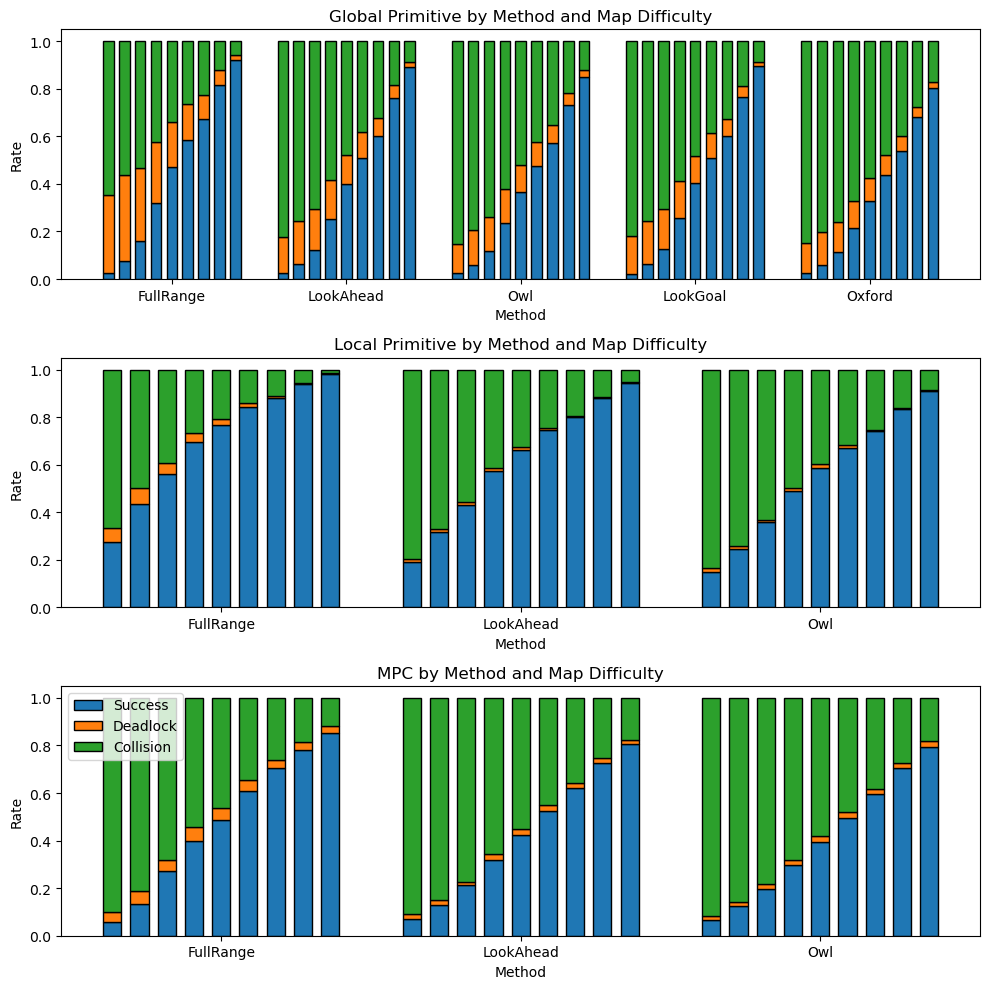

In [38]:


# Get the unique values of 'map difficulty' and 'Planner'
difficulties = df_results['map difficulty'].unique()
planners = df_results['Planner'].unique()

# Set the width of the bars and the distance between them
bar_width = 0.1
bar_distance = 0.2

# Set colors for success, deadlock, and collision
success_color = '#1f77b4'
deadlock_color = '#ff7f0e'
collision_color = '#2ca02c'

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=len(planners), figsize=(10, 10))

for ax, planner in zip(axs, planners):
    # Filter the DataFrame for the current planner
    df_filtered = df_results[df_results['Planner'] == planner]
    
    # Get the unique methods for this planner
    methods = df_filtered['Method'].unique()
    methods = sort_according_to(methods, preferred_order)

    bar_positions = np.arange(len(methods)) * (len(difficulties) * bar_width + bar_distance)
    
    for i, method in enumerate(methods):
        # Generate positions for each group of bars
        bar_position = i * (len(difficulties) * bar_width + bar_distance)


        # Filter the DataFrame for the current difficulty level
        df_filtered_method = df_filtered[df_filtered['Method'] == method]
        

        for j, difficulty in enumerate(difficulties):
            # Filter the DataFrame for the current method
            df_filtered_difficulty = df_filtered_method[df_filtered_method['map difficulty'] == difficulty]
        
            # Calculate the mean values
            mean_success = df_filtered_difficulty['Mean Success'].mean()
            mean_deadlock = df_filtered_difficulty['Mean Deadlock'].mean()

            # Create the bar plots
            bars_success = ax.bar(bar_position + j*bar_width, mean_success, width=bar_width/3*2, color=success_color, edgecolor='black')
            bars_deadlock = ax.bar(bar_position + j*bar_width, mean_deadlock, bottom=mean_success, width=bar_width/3*2, color=deadlock_color, edgecolor='black')
            bars_collision = ax.bar(bar_position + j*bar_width, 1 - mean_success - mean_deadlock, bottom=mean_success + mean_deadlock, width=bar_width/3*2, color=collision_color, edgecolor='black')

    # Set the x-ticks to be the methods, and adjust their positions to be in the center of the grouped bars
    
    ax.set_xticks(bar_positions + bar_width * (len(difficulties) - 1) / 2)
    ax.set_xticklabels(methods)

    # Set the axis labels and the title
    ax.set_xlabel('Method')
    ax.set_ylabel('Rate')
    ax.set_title(f'{planner} by Method and Map Difficulty')

# Display the legend
axs[-1].legend([bars_success, bars_deadlock, bars_collision], ['Success', 'Deadlock', 'Collision'])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()





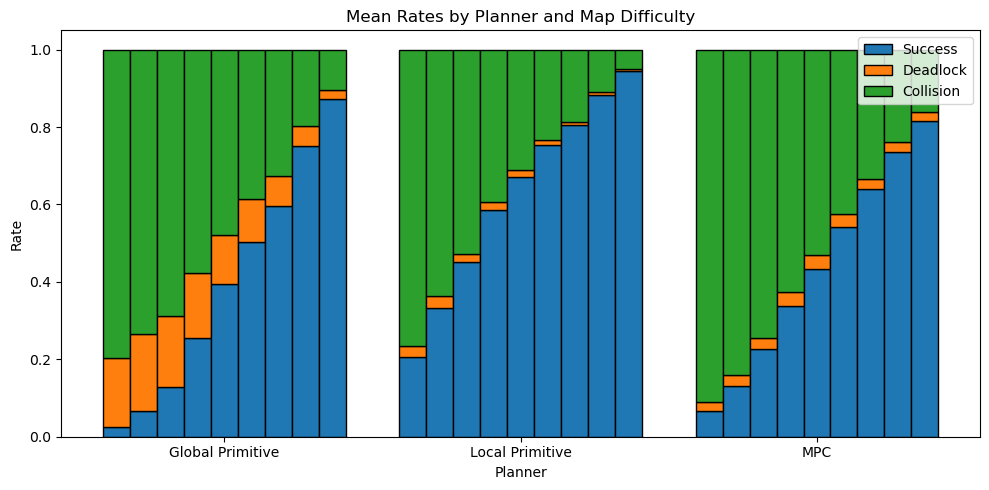

In [39]:
# Get the unique values of 'map difficulty' and 'Planner'
difficulties = df_results['map difficulty'].unique()
planners = df_results['Planner'].unique()

# Set the width of the bars and the distance between them
bar_width = 0.1
bar_distance = 0.2

# Set colors for success, deadlock, and collision
success_color = '#1f77b4'
deadlock_color = '#ff7f0e'
collision_color = '#2ca02c'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

bar_positions = np.arange(len(planners)) * (len(difficulties) * bar_width + bar_distance)

for i, planner in enumerate(planners):
    # Filter the DataFrame for the current planner
    df_filtered = df_results[df_results['Planner'] == planner]

    # Generate positions for each group of bars
    bar_position = i * (len(difficulties) * bar_width + bar_distance)

    for j, difficulty in enumerate(difficulties):
        # Filter the DataFrame for the current difficulty
        df_filtered_difficulty = df_filtered[df_filtered['map difficulty'] == difficulty]
        
        # Calculate the mean values
        mean_success = df_filtered_difficulty['Mean Success'].mean()
        mean_deadlock = df_filtered_difficulty['Mean Deadlock'].mean()

        # Create the bar plots
        bars_success = ax.bar(bar_position + j*bar_width, mean_success, width=bar_width, color=success_color, edgecolor='black')
        bars_deadlock = ax.bar(bar_position + j*bar_width, mean_deadlock, bottom=mean_success, width=bar_width, color=deadlock_color, edgecolor='black')
        bars_collision = ax.bar(bar_position + j*bar_width, 1 - mean_success - mean_deadlock, bottom=mean_success + mean_deadlock, width=bar_width, color=collision_color, edgecolor='black')

# Set the x-ticks to be the planners, and adjust their positions to be in the center of the grouped bars
ax.set_xticks(bar_positions + bar_width * (len(difficulties) - 1) / 2)
ax.set_xticklabels(planners)

# Set the axis labels and the title
ax.set_xlabel('Planner')
ax.set_ylabel('Rate')
ax.set_title('Mean Rates by Planner and Map Difficulty')

# Display the legend
ax.legend([bars_success, bars_deadlock, bars_collision], ['Success', 'Deadlock', 'Collision'])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


# test for different speed

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.contrib.itertools import product

import pandas as pd
import glob
import os

df_metric = pd.read_csv('./experiment/metrics/survivability/metrics_test_vel.csv')
metrics = []
for i in range(45):
    metrics.append(df_metric['metric'][i])
data = np.array(metrics).flatten()
metric_dict_test_vel = {}
round_metrics_dict_test_vel = {}
index = 0

for (agent_num, agent_size, map_id) in product([10, 20, 30], [5, 10, 15], range(5)):
    metric_dict_test_vel[(map_id, agent_num, agent_size, -1, 'CVM')] = data[index]
    round_metrics_dict_test_vel[(map_id, agent_num, agent_size, -1, 'CVM')] = round(data[index])
    index += 1

# Path to the directory
directory_path_test_vel = './experiment/test/'

# Find all csv files in the path that starts with "results_test_vel"
all_files = glob.glob(os.path.join(directory_path_test_vel, "results_test_vel*.csv")) 

# Create an empty list to hold dataframes
df_list = []

# Loop over the list of files and read each into a dataframe and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Concatenate all the dataframes in the list.
df_test_vel = pd.concat(df_list, ignore_index=True)
df_test_vel['Planner'] = df_test_vel['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df_test_vel['Method'] = df_test_vel['Method'].replace({'NoControl': 'FullRange'})

  0%|          | 0/45 [00:00<?, ?it/s]

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools


df_filtered_test_vel = df_test_vel[df_test_vel['Motion Profile'] == 'CVM']
# Define the columns to sort by
sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']

# Add a new column to the dataframe for the combinations of 'Method' and 'Planner'
df_filtered_test_vel['Method_Planner'] = df_filtered_test_vel['Method'] + "+" + df_filtered_test_vel['Planner']
df_filtered_test_vel['map difficulty'] = df_filtered_test_vel.apply(lambda row: metric_dict_test_vel.get((row['Map ID'], row['Number of agents'], row['Agent size'], row['Agent speed'], row['Motion Profile']), 'N/A'), axis=1)

# Calculate success rates for all combinations of parameters and 'Method_Planner'
df_filtered_test_vel['Parameters'] = df_filtered_test_vel[sort_columns].apply(tuple, axis=1)
df_grouped_test_vel = df_filtered_test_vel.groupby(['Method_Planner', 'Parameters'])['Success'].mean().reset_index()
df_grouped_test_vel['map difficulty'] = df_grouped_test_vel.apply(lambda row: metric_dict_test_vel.get(row['Parameters'], 'N/A'), axis=1)



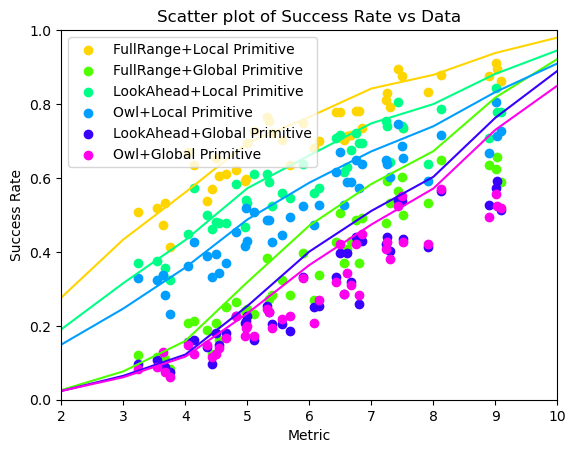

In [42]:
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_filtered_test_vel['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_vel = df_grouped_test_vel[df_grouped_test_vel['Method_Planner'] == method_planner]
    plt.scatter(df_plot_test_vel['map difficulty'], df_plot_test_vel['Success'], color=color_map[method_planner], label=method_planner)
    plt.plot(df_plot['map difficulty'], df_plot['Mean Success'], color=color_map[method_planner])

# Set the axis labels
plt.xlabel('Metric')
plt.ylabel('Success Rate')
plt.xlim(2, 10)
plt.ylim(0, 1)

# Set the title
plt.title('Scatter plot of Success Rate vs Data')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# test for different shaped

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.contrib.itertools import product

import pandas as pd
import glob
import os

df_metric = pd.read_csv('./experiment/metrics/survivability/metrics_test_shape.csv')
metrics = []
for i in range(45):
    metrics.append(df_metric['metric'][i])
data = np.array(metrics).flatten()
metric_dict_test_shape = {}
round_metrics_dict_test_shape = {}
index = 0

for (agent_num, agent_size, map_id) in product([10, 20, 30], [5, 10, 15], range(5)):
    metric_dict_test_shape[(map_id, agent_num, agent_size, -1, 'CVM')] = data[index]
    round_metrics_dict_test_shape[(map_id, agent_num, agent_size, -1, 'CVM')] = round(data[index])
    index += 1

# Path to the directory
directory_path_test_shape = './experiment/test/'

# Find all csv files in the path that starts with "results_test_vel"
all_files = glob.glob(os.path.join(directory_path_test_shape, "results_test_shape*.csv")) 

# Create an empty list to hold dataframes
df_list = []

# Loop over the list of files and read each into a dataframe and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Concatenate all the dataframes in the list.
df_test_shape = pd.concat(df_list, ignore_index=True)
df_test_shape['Planner'] = df_test_shape['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df_test_shape['Method'] = df_test_shape['Method'].replace({'NoControl': 'FullRange'})

  0%|          | 0/45 [00:00<?, ?it/s]

In [44]:
df_filtered_test_shape = df_test_shape[df_test_shape['Motion Profile'] == 'CVM']
df_filtered_test_shape['Method_Planner'] = df_filtered_test_shape['Method'] + "+" + df_filtered_test_shape['Planner']

df_filtered_test_shape['map difficulty'] = df_filtered_test_shape.index.map(lambda x: metrics[(x // 432) % 45])
df_grouped_test_shape = df_filtered_test_shape.groupby(['Method_Planner', 'map difficulty'])['Success'].mean().reset_index()

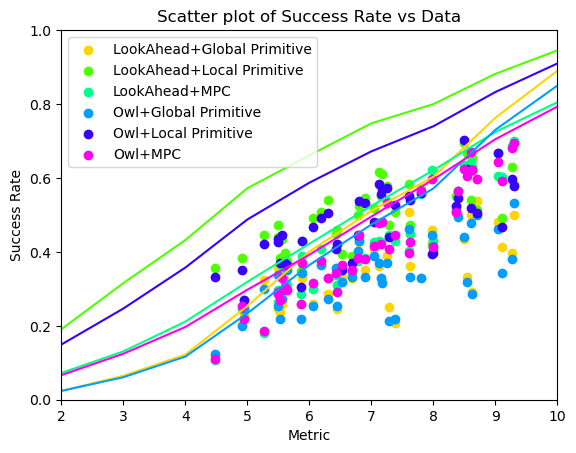

In [45]:
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_grouped_test_shape['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_shape = df_grouped_test_shape[df_grouped_test_shape['Method_Planner'] == method_planner]
    plt.scatter(df_plot_test_shape['map difficulty'], df_plot_test_shape['Success'], color=color_map[method_planner], label=method_planner)
    plt.plot(df_plot['map difficulty'], df_plot['Mean Success'], color=color_map[method_planner])

# Set the axis labels
plt.xlabel('Metric')
plt.ylabel('Success Rate')
plt.xlim(2, 10)
plt.ylim(0, 1)

# Set the title
plt.title('Scatter plot of Success Rate vs Data')

# Show the legend
plt.legend()

# Show the plot
plt.show()